In [1]:
import nibabel as nib
from matplotlib import pyplot as plt
from glob import glob
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import csv

# Oslo Dataset

In [3]:
directory = '/data/projects/TMOR/data_v2/Oslo/*/seg_*.nii.gz'
#oslo_dir = '/data/projects/TMOR/oslo_dir/{}_seg.png'
#os.makedirs(os.path.dirname(oslo_dir), exist_ok=True)

In [259]:

#for subdir, dir, files in os.walk(directory):
for file in tqdm(glob(directory)):
    file_dir = os.path.dirname(file) #reading the multiple files of the Brain Metastases
    subjid = file_dir.split(os.sep)[-1] #getting the name from the patients
    mris = sorted(glob(os.path.join(file_dir, '*.nii.gz')))
    #mris = mris[1:] + mris[:1] # placing the file with the segmnented brain metastasis first
    #putting all the images from a single patient together for better visualization
    fig, ax = plt.subplots(1, 1)
    for mri in mris:
        nii = nib.load(mri) #read the mris
        vol = nii.get_fdata() #get the volume from the images
        if mri == file:
            idx = vol.sum(0).sum(1).argmax() #aggregate over the two axis to find the tumors by the voxel values
            cmap_name = 'viridis'
        else:
            cmap_name = 'gray'
        mri_slice = vol[:, idx, :]
        ax.imshow(np.rot90(mri_slice), cmap=cmap_name)
        ax.set_title(os.path.basename(mri))
    fig.suptitle(f'ID: {subjid} - index: {idx} - n_tumor_voxels: {np.sum(mri_slice)}')
    fig.savefig(oslo_dir.format(subjid))
    plt.close(fig)

100%|██████████| 67/67 [00:08<00:00,  8.04it/s]


In [8]:
num_tumors = []
for file in glob(directory):
    nii = nib.load(file)
    vol = nii.get_fdata()
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1]
    num_tumors.append(len(np.unique(vol)) - 1)
    print(subjid, len(np.unique(vol)) - 1)

with open('/data/projects/TMOR/num_tumors_oslo.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['SubjectNumber', 'Number_tumors'])
    writer.writerows(num_tumors)

Subject01 2
Subject02 6
Subject03 4
Subject04 1
Subject05 2
Subject06 1
Subject07 4
Subject08 3
Subject09 2
Subject10 1
Subject11 1
Subject12 2
Subject13 1
Subject14 2
Subject15 4
Subject16 2
Subject17 1
Subject18 3
Subject19 1
Subject20 2
Subject21 1
Subject22 1
Subject23 1
Subject24 2
Subject25 12
Subject26 2
Subject27 2
Subject28 4
Subject29 2
Subject30 2
Subject31 3
Subject32 3
Subject33 2
Subject34 2
Subject35 2
Subject36 1
Subject37 2
Subject38 3
Subject39 1
Subject40 1
Subject41 3
Subject42 3
Subject43 5
Subject44 1
Subject45 5
Subject46 3
Subject47 1
Subject48 3
Subject49 4
Subject50 2
Subject51 2
Subject52 4
Subject53 2
Subject54 2
Subject55 3
Subject56 1
Subject57missingPreGd 1
Subject58missingPreGd 1
Subject59 1
Subject60 1
Subject61 1
Subject62 1
Subject63 4
Subject64 2
Subject65 4
Subject66 1


Error: iterable expected, not int

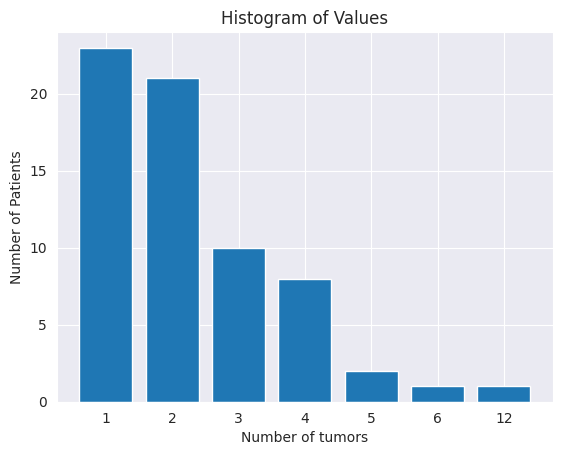

In [22]:
unique_values, value_counts = np.unique(num_tumors, return_counts=True)
y_pos = np.arange(len(unique_values))

plt.bar(y_pos, value_counts, align='center')
plt.xticks(y_pos, unique_values)
plt.ylabel('Number of Patients')
plt.xlabel('Number of tumors')
plt.title('Histogram of Values')
plt.ylim(0, max(value_counts) + 1)
plt.show()

In [13]:
print(Counter(num_tumors))

Counter({1: 23, 2: 21, 3: 10, 4: 8, 5: 2, 6: 1, 12: 1})


# Size of the tumors in the oslo dataset

In [23]:
tumor_sizes = []
for file in glob(directory):
    nii = nib.load(file) #read the data like before
    vol = nii.get_fdata() #obtain the info of the images
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1] #obtain the patient name
    for unique_value in np.unique(vol):
        if unique_value: #ignore the value 0
            print(subjid, np.sum(vol == unique_value))
            tumor_sizes.append(np.sum(vol == unique_value))

Subject01 741
Subject01 2339
Subject02 2
Subject02 15
Subject02 47
Subject02 549
Subject02 1699
Subject02 26
Subject03 2086
Subject03 63
Subject03 912
Subject03 11
Subject04 4054
Subject05 2
Subject05 44
Subject06 323
Subject07 11159
Subject07 22
Subject07 4
Subject07 4
Subject08 18
Subject08 90
Subject08 238
Subject09 3449
Subject09 24719
Subject10 9448
Subject11 9830
Subject12 17
Subject12 885
Subject13 13676
Subject14 11097
Subject14 23
Subject15 57
Subject15 20
Subject15 3
Subject15 41
Subject16 2
Subject16 25
Subject17 5517
Subject18 2709
Subject18 154
Subject18 207
Subject19 1893
Subject20 1162
Subject20 707
Subject21 731
Subject22 188
Subject23 186
Subject24 7557
Subject24 3335
Subject25 2
Subject25 16
Subject25 4
Subject25 6
Subject25 17
Subject25 10
Subject25 5
Subject25 3
Subject25 14
Subject25 9
Subject25 8922
Subject25 34
Subject26 439
Subject26 658
Subject27 42
Subject27 7
Subject28 5
Subject28 1
Subject28 13
Subject28 591
Subject29 2174
Subject29 97
Subject30 861
Subject3

In [42]:
np.median(tumor_sizes)

349.0

In [43]:
len(tumor_sizes)

155

Text(0, 0.5, 'NUmber of Patietns')

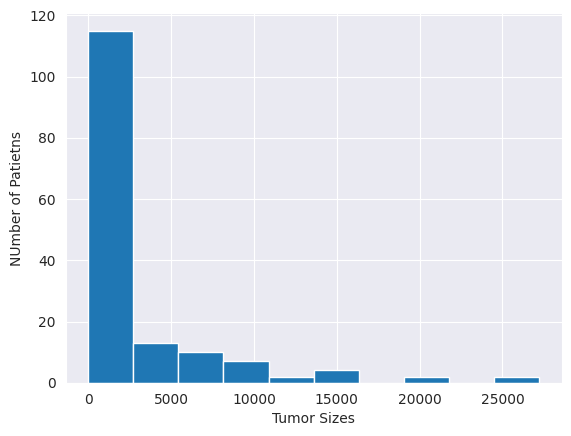

In [29]:
num_bins = 10
plt.hist(tumor_sizes, alpha = 1, bins=num_bins)
plt.xlabel('Tumor Sizes')
plt.ylabel('NUmber of Patietns')

There is a lot of little tumors that we might want to obviate. We will see that there is some patients with tumors sizes less than 10 voxels

In [39]:
tumor_sizes_smaller_than_125 = []
for file in glob(directory):
    nii = nib.load(file) #read the data like before
    vol = nii.get_fdata() #obtain the info of the images
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1] #obtain the patient name
    for unique_value in np.unique(vol):
        if np.sum(vol == unique_value) < 125: #ignore the value 0
            print(subjid, np.sum(vol == unique_value))
            tumor_sizes_smaller_than_125.append(np.sum(vol == unique_value))

Subject02 2
Subject02 15
Subject02 47
Subject02 26
Subject03 63
Subject03 11
Subject05 2
Subject05 44
Subject07 22
Subject07 4
Subject07 4
Subject08 18
Subject08 90
Subject12 17
Subject14 23
Subject15 57
Subject15 20
Subject15 3
Subject15 41
Subject16 2
Subject16 25
Subject25 2
Subject25 16
Subject25 4
Subject25 6
Subject25 17
Subject25 10
Subject25 5
Subject25 3
Subject25 14
Subject25 9
Subject25 34
Subject27 42
Subject27 7
Subject28 5
Subject28 1
Subject28 13
Subject29 97
Subject31 3
Subject32 1
Subject34 27
Subject35 6
Subject38 9
Subject41 14
Subject42 24
Subject42 7
Subject43 42
Subject43 9
Subject45 70
Subject45 2
Subject45 21
Subject46 31
Subject46 11
Subject48 20
Subject49 52
Subject50 1
Subject51 107
Subject52 18
Subject52 9
Subject54 20
Subject55 18
Subject55 117
Subject64 73
Subject64 59
Subject65 4


Text(0, 0.5, 'Number of Patietns')

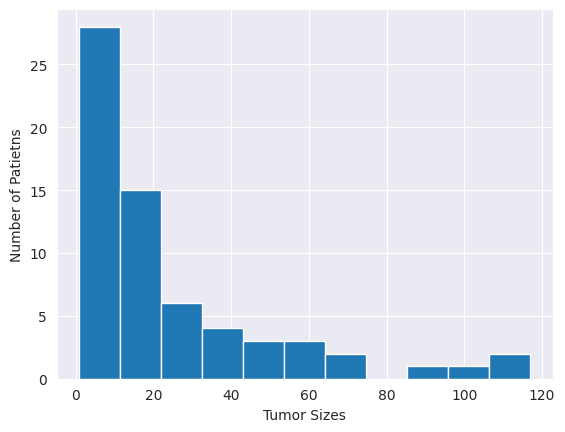

In [44]:
num_bins = 11
plt.hist(tumor_sizes_smaller_than_125, alpha = 1, bins=num_bins)
plt.xlabel('Tumor Sizes')
plt.ylabel('Number of Patietns')

In [32]:
len(tumor_sizes_smaller_than_125)

65

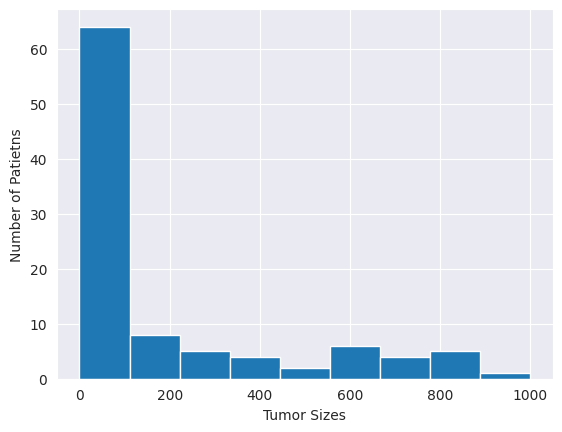

In [45]:
plt.hist(tumor_sizes, bins = 'auto', alpha = 1 ,range=[0, 1000])
plt.xlabel('Tumor Sizes')
plt.ylabel('Number of Patietns')
plt.show()

Overall all the tumors have a regular size, there might be some outliers, some tumors bigger than others but all those are of regular size. Nothing looks strange from the data nor the visualization of the tumors

# SRANFORD

In [51]:
directory = '/data/projects/TMOR/data_v2/Stanford/*/seg.nii.gz'
#standford_dir = '/data/projects/TMOR/STANDFORD_dir/{}_seg.png'
#os.makedirs(os.path.dirname(standford_dir), exist_ok=True)

In [262]:

for file in tqdm(glob(directory)):
    file_dir = os.path.dirname(file) #reading the multiple files of the Brain Metastases
    subjid = file_dir.split(os.sep)[-1] #getting the name from the patients
    mris = sorted(glob(os.path.join(file_dir, '*.nii.gz')))
    #mris = mris[1:] + mris[:1] # placing the file with the segmnented brain metastasis first
    #putting all the images from a single patient together for better visualization
    fig, ax = plt.subplots(1, 1)
    for mri in mris:
        nii = nib.load(mri)
        vol = nii.get_fdata()
        if mri == file:
            idx = vol.sum(0).sum(1).argmax()
            cmap_name = 'viridis'
        else:
            cmap_name = 'gray'
        mri_slice = vol[:, idx, :]
        ax.imshow(np.rot90(mri_slice), cmap=cmap_name)
        ax.set_title(os.path.basename(mri))
    fig.suptitle(f'ID: {subjid} - index: {idx} - n_tumor_voxels: {np.sum(mri_slice)}')
    fig.savefig(standford_dir.format(subjid))
    plt.close(fig)


100%|██████████| 156/156 [00:17<00:00,  8.71it/s]


In [55]:
num_tumors = []
for file in glob(directory):
    nii = nib.load(file)
    vol = nii.get_fdata()
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1]
    subjid = str(int(subjid.split('_')[-1]))
    num_tumors.append(len(np.unique(vol)) - 1)
    print(subjid, len(np.unique(vol)) - 1)

with open('/data/projects/TMOR/num_tumors_standford.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Patient_ID', 'Number_tumors'])
    writer.writerows(num_tumors)

5 3
9 13
10 3
11 3
13 2
14 11
16 6
19 16
21 16
24 70
25 3
26 13
28 11
29 1
30 1
32 5
33 2
36 3
37 5
38 5
39 8
40 7
41 3
42 8
44 19
45 2
46 1
47 16
49 16
51 12
52 173
53 26
54 41
55 18
58 17
59 22
62 16
63 9
64 46
65 7
66 43
68 4
69 17
72 3
74 3
81 8
87 2
88 2
89 2
90 7
92 1
94 3
95 13
96 9
97 1
98 5
99 6
100 2
101 9
102 1
107 48
111 12
112 1
120 161
121 156
122 9
123 10
126 2
127 1
128 3
132 29
134 94
136 62
142 8
143 9
144 7
146 2
148 1
149 2
151 3
154 10
163 1
165 1
166 15
167 8
170 16
171 2
173 7
176 16
177 4
181 55
183 2
184 5
185 4
187 61
189 7
192 12
196 4
197 8
203 21
213 3
218 5
225 10
227 4
230 1
232 2
234 4
235 4
237 4
238 4
240 7
241 2
244 11
246 3
248 1
249 6
251 5
252 120
256 3
257 8
260 3
265 13
266 72
271 17
273 1
274 1
277 11
279 2
280 54
282 1
283 85
285 2
287 1
289 15
290 1
291 2
296 2
297 13
298 3
303 9
306 1
307 11
309 8
311 1
312 3
313 13
314 68
315 25
316 15
318 10
319 14
321 5
323 23
326 1
328 16
338 4


Error: iterable expected, not int

In [36]:
num_tumors = []
for file in glob(directory):
    nii = nib.load(file)
    vol = nii.get_fdata()
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1]
    if len(np.unique(vol)) - 1 > 3:
        num_tumors.append((subjid,len(np.unique(vol)) - 1))
        print(subjid, len(np.unique(vol)) - 1)

Mets_009 13
Mets_014 11
Mets_016 6
Mets_019 16
Mets_021 16
Mets_024 70
Mets_026 13
Mets_028 11
Mets_032 5
Mets_037 5
Mets_038 5
Mets_039 8
Mets_040 7
Mets_042 8
Mets_044 19
Mets_047 16
Mets_049 16
Mets_051 12
Mets_052 173
Mets_053 26
Mets_054 41
Mets_055 18
Mets_058 17
Mets_059 22
Mets_062 16
Mets_063 9
Mets_064 46
Mets_065 7
Mets_066 43
Mets_068 4
Mets_069 17
Mets_081 8
Mets_090 7
Mets_095 13
Mets_096 9
Mets_098 5
Mets_099 6
Mets_101 9
Mets_107 48
Mets_111 12
Mets_120 161
Mets_121 156
Mets_122 9
Mets_123 10
Mets_132 29
Mets_134 94
Mets_136 62
Mets_142 8
Mets_143 9
Mets_144 7
Mets_154 10
Mets_166 15
Mets_167 8
Mets_170 16
Mets_173 7
Mets_176 16
Mets_177 4
Mets_181 55
Mets_184 5
Mets_185 4
Mets_187 61
Mets_189 7
Mets_192 12
Mets_196 4
Mets_197 8
Mets_203 21
Mets_218 5
Mets_225 10
Mets_227 4
Mets_234 4
Mets_235 4
Mets_237 4
Mets_238 4
Mets_240 7
Mets_244 11
Mets_249 6
Mets_251 5
Mets_252 120
Mets_257 8
Mets_265 13
Mets_266 72
Mets_271 17
Mets_277 11
Mets_280 54
Mets_283 85
Mets_289 15
Me

In [37]:
num_tumors
len(num_tumors)

100

In [270]:
num_tumors = []
for file in glob(directory):
    nii = nib.load(file)
    vol = nii.get_fdata()
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1]
    num_tumors.append((len(np.unique(vol)) - 1))
    print(subjid, len(np.unique(vol)) - 1)

Mets_005 3
Mets_009 13
Mets_010 3
Mets_011 3
Mets_013 2
Mets_014 11
Mets_016 6
Mets_019 16
Mets_021 16
Mets_024 70
Mets_025 3
Mets_026 13
Mets_028 11
Mets_029 1
Mets_030 1
Mets_032 5
Mets_033 2
Mets_036 3
Mets_037 5
Mets_038 5
Mets_039 8
Mets_040 7
Mets_041 3
Mets_042 8
Mets_044 19
Mets_045 2
Mets_046 1
Mets_047 16
Mets_049 16
Mets_051 12
Mets_052 173
Mets_053 26
Mets_054 41
Mets_055 18
Mets_058 17
Mets_059 22
Mets_062 16
Mets_063 9
Mets_064 46
Mets_065 7
Mets_066 43
Mets_068 4
Mets_069 17
Mets_072 3
Mets_074 3
Mets_081 8
Mets_087 2
Mets_088 2
Mets_089 2
Mets_090 7
Mets_092 1
Mets_094 3
Mets_095 13
Mets_096 9
Mets_097 1
Mets_098 5
Mets_099 6
Mets_100 2
Mets_101 9
Mets_102 1
Mets_107 48
Mets_111 12
Mets_112 1
Mets_120 161
Mets_121 156
Mets_122 9
Mets_123 10
Mets_126 2
Mets_127 1
Mets_128 3
Mets_132 29
Mets_134 94
Mets_136 62
Mets_142 8
Mets_143 9
Mets_144 7
Mets_146 2
Mets_148 1
Mets_149 2
Mets_151 3
Mets_154 10
Mets_163 1
Mets_165 1
Mets_166 15
Mets_167 8
Mets_170 16
Mets_171 2
Mets_17

In [267]:
for file in glob(directory):
    nii = nib.load(file)
    vol = nii.get_fdata()
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1]
    if len(np.unique(vol)) - 1 >= 75:
        print(subjid, len(np.unique(vol)) - 1)
    #num_tumors.append(len(np.unique(vol)) - 1)

Mets_052 173
Mets_120 161
Mets_121 156
Mets_134 94
Mets_252 120
Mets_283 85


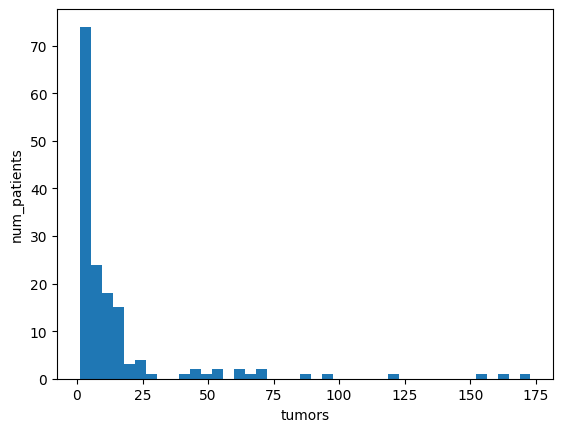

In [272]:
plt.hist(num_tumors, bins = 'auto', alpha = 1)
plt.xlabel('tumors')
plt.ylabel('num_patients')
plt.show()

In [273]:
print(Counter(num_tumors))

Counter({1: 21, 2: 18, 3: 17, 4: 10, 16: 8, 5: 8, 8: 8, 7: 7, 13: 6, 9: 6, 11: 5, 10: 4, 6: 3, 12: 3, 17: 3, 15: 3, 70: 1, 19: 1, 173: 1, 26: 1, 41: 1, 18: 1, 22: 1, 46: 1, 43: 1, 48: 1, 161: 1, 156: 1, 29: 1, 94: 1, 62: 1, 55: 1, 61: 1, 21: 1, 120: 1, 72: 1, 54: 1, 85: 1, 68: 1, 25: 1, 14: 1, 23: 1})


The distribution from tumors from this dataset is rather odd. As we can see there are with more than a hundred brain metastases. This cannot be correct and I hypothesize is an error from the program as it is strange that a radiologist segmented for one individual little tumors in the brain. Same logic for any patient with more than 15 brain metastasis segmennted. For this cases in the 3D visualization it can be observed multiple little brain tumors. We can also find more patients that apparently have np brain metastases than the previous dataset. Need to contact Jon about this data.

<Axes: >

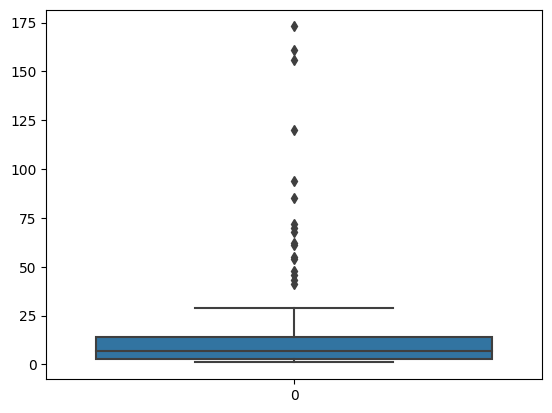

In [274]:
sns.boxplot(num_tumors)

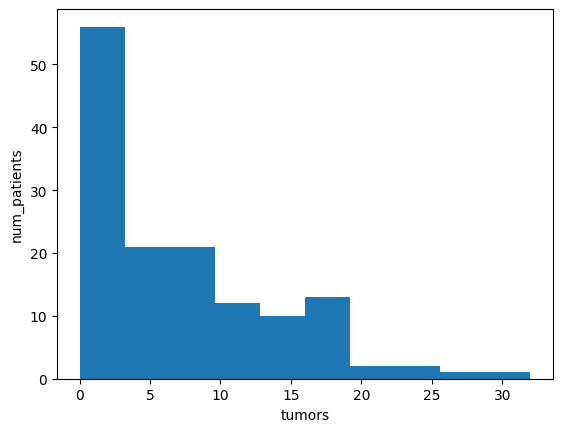

In [277]:
plt.hist(num_tumors, bins = 'auto', alpha = 1, range =[0, 32])
plt.xlabel('tumors')
plt.ylabel('num_patients')
plt.show()

In [281]:
tumor_sizes = []
for file in glob(directory):
    nii = nib.load(file)
    vol = nii.get_fdata()
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1]
    for unique_value in np.unique(vol):
        if unique_value:
            print(subjid, np.sum(vol == unique_value))
            tumor_sizes.append(np.sum(vol == unique_value))

Mets_005 403
Mets_005 194
Mets_005 192
Mets_009 113
Mets_009 13
Mets_009 51
Mets_009 44
Mets_009 29
Mets_009 8
Mets_009 16
Mets_009 1229
Mets_009 26
Mets_009 17
Mets_009 4
Mets_009 80
Mets_009 154
Mets_010 509
Mets_010 30
Mets_010 1067
Mets_011 37
Mets_011 56
Mets_011 66
Mets_013 39
Mets_013 26
Mets_014 12
Mets_014 35
Mets_014 26
Mets_014 46
Mets_014 190
Mets_014 779
Mets_014 166
Mets_014 51
Mets_014 226
Mets_014 266
Mets_014 184
Mets_016 70
Mets_016 3025
Mets_016 1765
Mets_016 57
Mets_016 8112
Mets_016 9729
Mets_019 20
Mets_019 2170
Mets_019 17
Mets_019 32
Mets_019 15
Mets_019 13
Mets_019 143
Mets_019 58
Mets_019 11
Mets_019 38
Mets_019 32
Mets_019 802
Mets_019 19
Mets_019 20
Mets_019 37
Mets_019 91
Mets_021 136
Mets_021 10
Mets_021 11
Mets_021 93
Mets_021 54
Mets_021 295
Mets_021 89
Mets_021 55
Mets_021 47
Mets_021 13
Mets_021 34
Mets_021 20
Mets_021 14
Mets_021 26
Mets_021 30
Mets_021 377
Mets_024 130
Mets_024 14
Mets_024 8
Mets_024 4
Mets_024 12
Mets_024 15
Mets_024 12
Mets_024 19


In [ ]:
for file in glob(directory):
    nii = nib.load(file)
    vol = nii.get_fdata()
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1]
    for unique_value in np.unique(vol):
        if unique_value:
            if np.sum(vol == unique_value) > 30000:
                print(subjid)
            #tumor_sizes.append(np.sum(vol == unique_value))

In [40]:
tumor_sizes = []
for file in glob(directory):
    nii = nib.load(file)
    vol = nii.get_fdata()
    file_dir = os.path.dirname(file)
    subjid = file_dir.split(os.sep)[-1]
    for unique_value in np.unique(vol):
        if unique_value:
            if np.sum(vol == unique_value) < 126:
                print(subjid, np.sum(vol == unique_value))
                tumor_sizes.append(np.sum(vol == unique_value))

Mets_009 113
Mets_009 13
Mets_009 51
Mets_009 44
Mets_009 29
Mets_009 8
Mets_009 16
Mets_009 26
Mets_009 17
Mets_009 4
Mets_009 80
Mets_010 30
Mets_011 37
Mets_011 56
Mets_011 66
Mets_013 39
Mets_013 26
Mets_014 12
Mets_014 35
Mets_014 26
Mets_014 46
Mets_014 51
Mets_016 70
Mets_016 57
Mets_019 20
Mets_019 17
Mets_019 32
Mets_019 15
Mets_019 13
Mets_019 58
Mets_019 11
Mets_019 38
Mets_019 32
Mets_019 19
Mets_019 20
Mets_019 37
Mets_019 91
Mets_021 10
Mets_021 11
Mets_021 93
Mets_021 54
Mets_021 89
Mets_021 55
Mets_021 47
Mets_021 13
Mets_021 34
Mets_021 20
Mets_021 14
Mets_021 26
Mets_021 30
Mets_024 14
Mets_024 8
Mets_024 4
Mets_024 12
Mets_024 15
Mets_024 12
Mets_024 19
Mets_024 1
Mets_024 48
Mets_024 23
Mets_024 67
Mets_024 7
Mets_024 38
Mets_024 10
Mets_024 14
Mets_024 21
Mets_024 13
Mets_024 7
Mets_024 42
Mets_024 36
Mets_024 19
Mets_024 5
Mets_024 14
Mets_024 16
Mets_024 21
Mets_024 10
Mets_024 30
Mets_024 14
Mets_024 49
Mets_024 10
Mets_024 12
Mets_024 32
Mets_024 4
Mets_024 23


In [41]:
len(tumor_sizes)

1969

<Axes: ylabel='Count'>

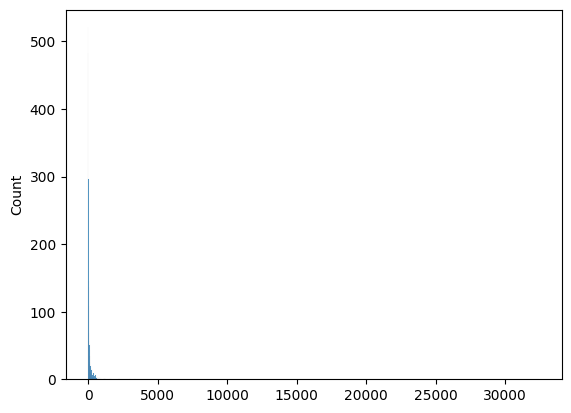

In [283]:
sns.histplot(tumor_sizes)

<function matplotlib.pyplot.show(close=None, block=None)>

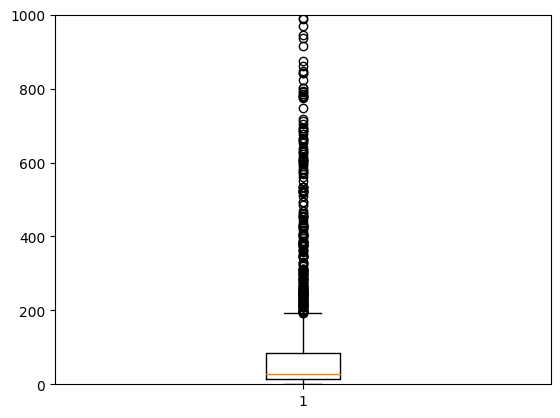

In [286]:
plt.boxplot(tumor_sizes)
plt.ylim(0, 1000)
plt.show

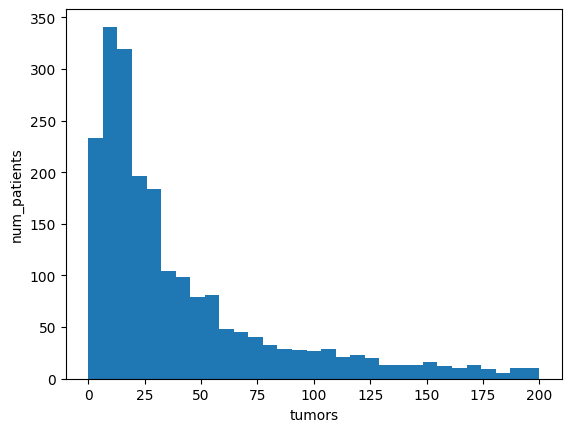

In [288]:
plt.hist(tumor_sizes, bins = 'auto', alpha = 1, range=[0, 200])
plt.xlabel('tumors')
plt.ylabel('num_patients')
plt.show()

In [291]:
max(tumor_sizes)

32446